# HappyDB: applying data science to analyze 100,000 happy moments

## Introduction

### Dataset
HappyDB is a dataset of more than 100,000 happy moments crowd-sourced via Amazon’s Mechanical Turk.

Each worker was given the following task:

1. What made you happy today?
2. Reflect on the past 24 hours, and recall three actual events that happened to you that made you happy.
3. Write down your happy moment in a complete sentence. (Write three such moments.)

The second dataset contains demographic information of the respondents: age, gender, marriage status, etc.

### Objectives
The goal of this notebook is to analyze these happy moments and advance the understanding of the causes of happiness by applying data analysis and machine-learning techniques.


### Table of content
There are three main sections:
* Sections 1 and 2 conduct some Exploratory Data Analysis (EDA), feature engineering and descriptive analysis;
* Sections 3 to 5 apply a MultinomialNB Classifier model to predict gender, marriage status, parenthood, age and country based on the happy moment text content, and using Term Frequency, Inverse Document Frequency (TFIDF);
* Section 6 extracts meaningful keywords by type of responses and respondents' characteristics using Python's standard Text Processing techniques.

### In summary
- Prediction model:
    - The happy moments text content allows to **predict the country** (USA or not) and **age** (younger than 25 or not) with **prediction accuracies greater than 0.80**.
    - The other features can be predicted with a **precision between 0.60 and 0.70** (not that bad, but not as good).
- The last sections **summarizes what makes up happy moments**:
    - By category
    - By country
    - By gender
    - By marital status
    - By parenthood

This notebook expands the initial analysis from Chen Chen in his very good kernel from Chen Chen titled HappyDB analysis.
### Check other Kaggle notebooks from [Yvon Dalat](https://www.kaggle.com/ydalat):
* [Titanic, a step-by-step intro to Machine Learning](https://www.kaggle.com/ydalat/titanic-a-step-by-step-intro-to-machine-learning): **a practice run ar EDA and ML-classification**
* [HappyDB, a step-by-step application of Natural Language Processing](https://www.kaggle.com/ydalat/happydb-what-100-000-happy-moments-are-telling-us): **find out what 100,000 happy moments are telling us**
* [Work-Life Balance survey, an Exploratory Data Analysis of lifestyle best practices](https://www.kaggle.com/ydalat/work-life-balance-best-practices-eda): **key insights into the factors affecting our work-life balance**
*  [Work-Life Balance survey, a Machine-Learning analysis of best practices to rebalance our lives](https://www.kaggle.com/ydalat/work-life-balance-predictors-and-clustering): **discover the strongest predictors of work-life balance**

**Interested in more facts and data to balance your life, check https://amzn.to/2MFO6Iy
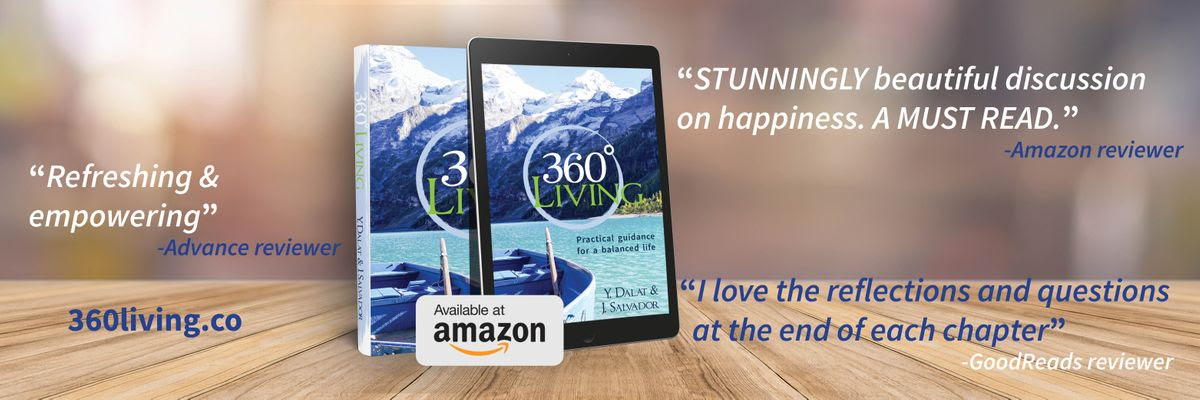**


## Import libraries

In [ ]:
# Import libraries: visualizaiton, text analysis and classifiers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import nltk
import string
import nltk.corpus
import nltk.stem.snowball
from nltk.corpus import wordnet
# Get default English stopwords and extend with punctuation
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
# You first have to install the worldcloud libraries (like all other ones)
# I used: conda install -c https://conda.anaconda.org/conda-forge wordcloud in the command prompt

## Load datasets

In [ ]:
# Load happy dataset
happy = pd.read_csv('../input/happydb/cleaned_hm.csv')
happy.head(2)

In [ ]:
# Load demographic dataset
demographic = pd.read_csv('../input/demographic-cleaned/demographic_cleaned.csv')

# RUN THIS FUNCTION ONLY ONCE AND SAVE demographic_cleaned.csv IN YOUR ACTIVE DIRECTORY
# clean_string function to remove text string but keep number string, float and integer
# I ran the clean_string function below only once and saved the cleaned dataframe as demographic_cleaned.csv
# For all subsequent analysis, I then import demographic_cleaned.csv directly in order to avoid cleaning data each time.

#def clean_string(df, column):
#    for i in range(0,len(df)):
#        if type(df[column][i])==str:
#            df[column][i] = df[column][i].split('.')[0]
#            if df[column][i].isdigit()==False:
#                df[column][i]=50
#    return df
#demographic = clean_string(demographic, 'age')

#demographic.head(2)
#demographic.to_csv("demographic_cleaned.csv", index=False)

## 1. Exploratory Data Analysis (EDA) and feature engineering
### 1.1 Dataset size and description

In [ ]:
happy.info()

In [ ]:
demographic.info()

In [ ]:
#Dataset reduction during development/testing stages
#happy = happy[1:50000] #Smaller dataset to test code before final run with full dataset
#demographic = demographic[1:5000] # Could also use .sample(frac=0.10)

## 1.2 Text length (count of words)

In [ ]:
#Create additional column with length of cleaned_hm
happy['length'] = happy['cleaned_hm'].apply(lambda x: len(x.split()))
#happy[happy['reflection_period']== '24h'].head(2)
happy.head(2)

## 1.3 Merging datasets

In [ ]:
happy = pd.merge(happy, demographic, on='wid', validate = 'm:1')
#pd.pivot_table(happy, values='hmid',index='reflection_period', aggfunc='count')
happy.head(3)

## 1.4 Converting categorical features into numerical values
### reflection_period

In [ ]:
# reflection_period: replace 3m by 1, 24h by 0
happy.loc[happy['reflection_period']=='24h', 'reflection_period']=0
happy.loc[happy['reflection_period']=='3m', 'reflection_period']=1
happy.rename(columns={'3m': '3m or 24h'}, inplace=True)

In [ ]:
# Switching relection_priod column to the end in order to keep all features to analyse together
cols = happy.columns.tolist()
cols=['hmid',
 'wid',
 'cleaned_hm',
 'num_sentence',
 'predicted_category',
 'length',
 'age',
 'country',
 'gender',
 'marital',
 'parenthood',
 'reflection_period']
happy = happy[cols]
happy.head(2)

### marital status

In [ ]:
pd.pivot_table(happy, values='hmid',index='marital', aggfunc='count')

In [ ]:
# Replace marital with numerical values: married=1 or not-married=0
happy.loc[happy['marital']=='single', 'marital']=0
happy.loc[happy['marital']=='married', 'marital']=1
happy.loc[happy['marital']=='separated', 'marital']=0
happy.loc[happy['marital']=='divorced', 'marital']=0
happy.loc[happy['marital']=='widowed', 'marital']=0
#happy[(happy['marital']!=1) & (happy['marital']!=0)]

In [ ]:
happy['marital'].dropna(inplace=True) # drops rows with missing marital values

In [ ]:
pd.pivot_table(happy, values='hmid',index='marital', aggfunc='count')

### gender

In [ ]:
pd.pivot_table(happy, values='hmid',index='gender', aggfunc='count')

In [ ]:
# Replace gender with numerical values
happy.loc[happy['gender']=='m', 'gender']=0
happy.loc[happy['gender']=='f', 'gender']=1
happy.loc[happy['gender']=='o', 'gender']=0

### predicted_category

In [ ]:
pd.pivot_table(happy, values='hmid',index='predicted_category', aggfunc='count')

In [ ]:
# Replace predicted_category by numerical values aligned to 360 Living categories
happy.loc[happy['predicted_category']=='achievement', 'predicted_category']=3
happy.loc[happy['predicted_category']=='affection', 'predicted_category']=6
happy.loc[happy['predicted_category']=='bonding', 'predicted_category']=5
happy.loc[happy['predicted_category']=='enjoy_the_moment', 'predicted_category']=2
happy.loc[happy['predicted_category']=='exercise', 'predicted_category']=1
happy.loc[happy['predicted_category']=='leisure', 'predicted_category']=7
happy.loc[happy['predicted_category']=='nature', 'predicted_category']=4
happy.head(2)

### parenthood and country

In [ ]:
pd.pivot_table(happy, values='hmid',index='parenthood', aggfunc='count')

In [ ]:
# Replace parenthood
happy.loc[happy['parenthood']=='n', 'parenthood']=0
happy.loc[happy['parenthood']=='y', 'parenthood']=1

In [ ]:
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

In [ ]:
# Replace country by numerical values only for top5 countries, all others are 5
happy.loc[happy['country']=='USA', 'country']=1
happy.loc[happy['country']=='IND', 'country']=0
happy.loc[happy['country']=='VEN', 'country']=0
happy.loc[happy['country']=='CAN', 'country']=0
happy.loc[happy['country']=='GBR', 'country']=0
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

In [ ]:
def convert_string(x):
    if isinstance(x, str) == True:
        return 0
    else: return x
happy['country']=happy['country'].apply(lambda x: convert_string(x))
#happy['country']=int(happy['country'])
#pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('country', ascending=True)
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

# 2. Descriptive Analysis
## 2.1 Distribution
### age distribution

In [ ]:
happy=happy[happy['age']<150] # Drop rows with age exceeding 150 years
# Create plotly interactive chart df[column][i].isdigit()==False
happy['age'].iplot(kind='hist', bins=50, filename = 'happyDB_Age')

In [ ]:
happy.loc[happy['age']<25,  'age']=0
happy.loc[happy['age']>=25, 'age']=1
happy.head(1)

**Observation**: age feature is close to a normal Gaussian distrubution, slightly skewed to the right.

### Distribution of predicted_category, length and num_sentence

In [ ]:
#happy_numerical = happy.drop({'hmid', 'wid', 'country', 'age', 'cleaned_hm', 'num_sentence'}, axis=1)
fig, (axis1,axis2, axis3) = plt.subplots(1,3,figsize=(16,3))
sns.distplot(happy['predicted_category'], bins=20, ax=axis1)
sns.distplot(happy['length'], bins=20, ax=axis2)
sns.distplot(happy['num_sentence'], bins=20, ax=axis3)

**Observation**:
- Most responses are in categories 3 "Achievement" and 6 "Affection"
- All messages, except for some outliers, are less than 100 words, and less than 5 sentences

## 2.2 Bi-variate analysis

In [ ]:
g = sns.FacetGrid(data=happy, col='marital')
g.map(plt.hist,'predicted_category', bins=50)

In [ ]:
sns.boxplot(x='predicted_category', y='length', data=happy, palette = 'viridis')

In [ ]:
happy2 = happy.drop({'hmid', 'wid', 'num_sentence'}, axis=1)
sns.heatmap(happy2.groupby('predicted_category').mean().corr(), cmap='coolwarm')

# 3. MultinomialNB Classifier for selected feature
## 3.1 Preparing data

In [ ]:
# Extract ith column of happy dataframe only for values equal to 0 or 1
i=11 # Selecting feature in this column (counting from 0)
happy_class = happy[(happy.ix[:,i]==0) | (happy.ix[:,i]==1)]
X=happy_class['cleaned_hm']
y=happy_class.ix[:,i]
y = np.asarray(y,dtype=np.float64) # Convert y to float64 format

In [ ]:
CV = CountVectorizer()

In [ ]:
X = CV.fit_transform(X) # Create vectors with frequency info for each rating text description

## 3.2 Train Test Split and training model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(X_train, y_train)

## 3.3 Predictions and model evalaution

In [ ]:
predictions = nb.predict(X_test)
acc_nb = nb.score(X_test, y_test) # Return the mean accuracy
print('Classification Report \n',classification_report(y_test, predictions))
print('\n Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test, predictions), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

In [ ]:
acc_nb

# 4 Prediction using Term Frequency, Inverse Document Frequency (TFIDF), then applying the same MultinomialNB Classifier
- TF-IDF stands for term frequency-inverse document frequency.
- The tf-idf weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.
- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.
- Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

## 4.1 Preparing data

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
	('tfidf', TfidfTransformer()),
	('Classifier', MultinomialNB())
	])

## 4.2 Train Test Split and training model

In [ ]:
# Extract ith column of happy dataframe only for values equal to 0 or 1
i=7 # Selecting feature in this column (counting from 0)
happy_class = happy[(happy.ix[:,i]==0) | (happy.ix[:,i]==1)]
X=happy_class['cleaned_hm']
y=happy_class.ix[:,i]
y = np.asarray(y,dtype=np.float64) # Convert y to float64 format
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
pipeline.fit(X_train, y_train)

## 4.3 Predictions

In [ ]:
predictions = pipeline.predict(X_test)
print('Classification Report \n',classification_report(y_test, predictions))
print('\n Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test, predictions), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

#### Observations: using Term Frequency, Inverse Document Frequency (TFIDF) does not improve the quality of the prediction for this dataset.

# 5 Evaluating prediction accuracies for multiple features

## 5.1 Predictions for country,	gender,	marital, parenthood, 3m or 24h
- 6th column   age:        0 younger than 25, 1 older than 25
- 7th column   country:    1 USA, O outside of USA (India, Venezuela, Canada, GBR)
- 8th column   gender:     1 female, 0 male excluding others
- 9th column   marital:    1 married, 0 single or divorced or separated or widowed
- 10th column  parenthood: 1 yes, 0 no
- 11th column  3m or 24h:  1 3 months, 0 24 hours

In [ ]:
# Apply MultinomialNB classifier to other features, save scores for display
# Same logic as above but for each feature
accuracies_data=np.arange(5.0) # Create dataframe accuracies_data to store all scores

for i in range(7,12):
    # 1 Extract column i of happy dataframe only for values equal to 0 or 1, then split test from train data
    happy_class = happy[(happy.ix[:,i]==0) | (happy.ix[:,i]==1)]
    X = happy_class['cleaned_hm'] # Text column only
    y = happy_class.ix[:,i]
    y = np.asarray(y, dtype=np.float64)
    # Create vectors with frequency info for each text description
    CV = CountVectorizer()
    X  = CV.fit_transform(X) # creates vectors with frequency info for each rating text description
    
    # 2 Train Test Split, create instance and train classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    # 3 Apply predictor for test data
    predictions = nb.predict(X_test)
    accuracies_data[i-7] = nb.score(X_test, y_test)
accuracies_data

In [ ]:
# Display results
accuracies_data = accuracies_data.round(4) # Round all values to 4 digits
objects = ('country (USA or not)',
           'gender (female or male/other)',
           'marital (married or not)',
           'parenthood (yes or no)',
           'Reflexion (3 months or 24 hours)')
y_pos = np.arange(len(objects))   
plt.figure(figsize=(12,3))
plt.barh(y_pos, accuracies_data, left = 0, align='center', alpha=0.5,
         color=['green', 'grey', 'purple', 'orange', 'red'], tick_label= accuracies_data)
plt.yticks(y_pos, objects, rotation='horizontal')
plt.xticks(np.arange(0.5, 1, step=0.05))
#plt.axes([0.2,0.1,0.9,0.9])
plt.xlabel('Accuracy (f1-score)')
for i, v in enumerate(accuracies_data):
    plt.text(1, i, str(v), color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Classifier Outcome')
plt.show()

In [ ]:
happy.head(2)

# 6 Text Processing and Analysis
## 6.1 Pre-Processing

In [ ]:
happy = pd.read_csv('../input/happydb/cleaned_hm.csv')
happy=happy.head(5000) # Development/Testing: 5000
demographic = pd.read_csv('../input/demographic-cleaned/demographic_cleaned.csv')
#demographic = demographic[1:50000] #.sample(frac=0.1
# List of common words to remove, many thanks Chen-Chen for the initial inputs
nolist = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going',
'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday',
'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without',
'yesteri', '2s', 'toand', 'ing', 'got', 'came', 'could', 'happiness', 'new', 'able', 'finally', 'like',
'old', 'years', 'many', '2', 'get', 'taj', 'nice', 'top', 'back']

happy = pd.merge(happy, demographic, on='wid')
happy.drop('age', axis=1, inplace=True)

#happy=happy[happy['age']<150] # Drop rows with age exceeding 150 years
#happy.loc[happy['age']<25,  'age'] = 0
#happy.loc[happy['age']>=25, 'age'] = 1

In [ ]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)   
    # Now just remove any stopwords
    return [word for word in nopunc.split()
    if ((word.lower() not in stopwords) & (word.lower() not in nolist))]
# Apply to entire happy dataset, column cleaned_hm
happy['cleaned_hm'] = happy['cleaned_hm'].apply(text_process) #Sample of 10,000 rows
happy.head(1)

In [ ]:
# Convert list into string by joining words with a space
for i in range(0, len(happy)):
    happy['cleaned_hm'][i] = ' '.join(happy['cleaned_hm'][i])

## 6.2 Word Cloud

In [ ]:
text = ' '.join(happy['cleaned_hm'].tolist())
wordcloud = WordCloud(background_color="white", height=2200, width=4000).generate(text)
plt.figure( figsize=(18,7) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

## 6.3 Key words analysis for selected label of predicted_category feature
This section extracts the 10 most frequently used keywords (excl. punctuations and stop words) for a selected label  (number j) of the predicted_category.

In [ ]:
k = 8
# Extract unique values of predicted_category and add to a list in descending orders (by count of responses)
pivot_category = pd.pivot_table(happy, values='hmid',index=happy.ix[:,k], aggfunc='count')
pivot_category.sort_values('hmid', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
Category_labels =pivot_category.T.columns.tolist()
if len(Category_labels)>10:
    Category_labels = Category_labels[0:9]
Category_labels

In [ ]:
# Select text from this sub-category j (from above list) and convert into a string with spaces
j=1
text = ' '.join(happy[happy.ix[:,k]==Category_labels[j]]['cleaned_hm'].tolist())

In [ ]:
# Find frequency of each word in this text
# break the string into list of words, reset variables str2 and str3
str = text.split()         
str2 = []
str3 = pd.DataFrame([['A','B']], [Category_labels[j]], ['Word','Frequency'])
 
# Check for duplicate by looping until string values is not present in str
for word in str:
    if (word not in str2) & ((word+'s') not in str2):
        str2.append(word) # insert value in str2

# Create dataframe to store and report results
str3.ix[0][0]=str2[0]
str3.ix[0][1]=str.count(str2[0]) / len(text)
for i in range(1, len(str2)):
    # count the frequency of each word(present # in str2 and add with word to DataFrame
    freq = str.count(str2[i]) / len(text)
    str4 = pd.DataFrame([[str2[i],freq]], [Category_labels[j]], ['Word','Frequency'])
    str3 = str3.append(str4)  

str3.sort_values(by = 'Frequency', ascending=False, inplace=True)
str4 = str3.head(10)

In [ ]:
objects = str4['Word']
x_pos = np.arange(len(objects))   
plt.figure(figsize=(15,3))
colors = tuple(np.where(str4['Frequency']>(0.66*str4['Frequency'].max()), 'g', 'orange'))
plt.bar(x_pos, str4['Frequency'], align='center', alpha=0.5,
         color=colors)
plt.ylim(0, str4['Frequency'].max())
plt.xticks(x_pos, objects, rotation=90)
plt.xlabel('Most frequent words')
plt.ylabel('Frequency in this sub-category')
#for i, v in enumerate(str4['Frequency']):
#plt.text(1, i, str(v), color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Keywords in sub-category: {}'.format(Category_labels[j]))
plt.show()

## 6.3 Key words analysis for all labels of multiple features
The goal in this section is to extract the most frequent, meaningful keywords:
- For selected features: predicted_category, country, gender, marital,parenthood
- And within each feature, for each possible value or label. I limit countries to the top8 respondents, as the list is too long. 

In [ ]:
for k in range(8, 12): # Feature k
    
    # Extract unique values of predicted_category and add to a list in descending orders (by count of responses)
    pivot_category = pd.pivot_table(happy, values='hmid',index=happy.ix[:,k], aggfunc='count')
    pivot_category.sort_values('hmid', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
    Category_labels =pivot_category.T.columns.tolist()
    add_title = ''
    if len(Category_labels)>10:
        Category_labels = Category_labels[0:8]
        add_title = '(Top 8)'

    j = 0 # Labels j for selected features
    str5={0:[]}
    fig = plt.figure(figsize=(18, 8))
    plt.title('Feature: '+happy.columns[k])
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    #fig, axis = plt.subplots(1,len(Category_labels),figsize=(18,3))
    for j in range(0, len(Category_labels)):
        l=j+1
        text = ' '.join(happy[happy.ix[:,k]==Category_labels[j]]['cleaned_hm'].tolist())
        str = text.split()         
        str2 = []
        str3 = pd.DataFrame([['A','B']], [Category_labels[j]], ['Word','Frequency'])
    
    # Check for duplicate by looping until string values is not present in str
        for word in str:
            if (word not in str2) & ((word+'s') not in str2):
                str2.append(word) # insert value in str2

    # Create dataframe to store and report results
        str3.ix[0][0]=str2[0]
        str3.ix[0][1]=str.count(str2[0]) / len(text)
        for i in range(1, len(str2)):
            # count the frequency of each word(present # in str2 and add with word to DataFrame
            freq = str.count(str2[i]) / len(text) 
            str4 = pd.DataFrame([[str2[i],freq]], [Category_labels[j]], ['Word','Frequency'])
            str3 = str3.append(str4)  

        str3.sort_values(by = 'Frequency', ascending=False, inplace=True)
        str4 = str3.head(10)
        str5.update({j: str4}) #add result to the list str 5 to create graphs in next section 
    
        # Graphing
        plt.subplot(2, 4, l)
        objects = str5[j]['Word']
        x_pos = np.arange(len(objects))   
        colors = tuple(np.where(str5[j]['Frequency']>(0.66*str5[j]['Frequency'].max()), 'g', 'orange'))
        sns.barplot(x=x_pos, y=str5[j]['Frequency'], palette=colors, alpha=0.6, data=happy);
        plt.text(0, (str5[j]['Frequency'].max()*1.05), 'Label: ' + Category_labels[j]
        +'\nFeature: '+happy.columns[k]+' '+add_title)
        plt.ylim((str5[j]['Frequency'].max()*0.1), (str5[j]['Frequency'].max()*1.2))
        plt.xticks(x_pos, objects, rotation=90)

plt.show()